In [1]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py
import bz2
import multiprocessing as mp


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors, KDTree

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

# Extracting the point collection and the descriptors

In [31]:
with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)
    
with open('descriptors/new_complete_res5_4by5_descriptors.pickle','rb') as f:
    descriptors = pickle.load(f)
    
with open('descriptors/new_complete_RANSAC_res5_4by5_descriptors.pickle','rb') as f:
    ransac_descriptors = pickle.load(f)

In [34]:
# We'll use only a 300 samples for this.
with open('sample_points.pickle','rb') as f:
    sample_points = pickle.load(f)
    
sample_points_300 = np.random.choice(1000,300,False)

len(sample_points), len(sample_points_300)

(1000, 300)

# Raw spaces (validation)

In [39]:
descriptors = descriptors

for radius in np.arange(0.25,2.1,0.5):
    
    t0 = time.time()
    t1 = time.time()
    
    partial_scores_pool = []
    
    print("radius =",radius)
    
    for s_i in sample_points_300:
        
        obj_, object_name, original_vertex = sample_points[s_i]
        
        pointCloud = []
        
        try:
            object_, pointCloud_, tri_ = new_contiguous_point_collection[int(obj_)]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
        except:
            print("Can't get partial samples for",obj_meta[0])
            continue
            
        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        local_keypoint_matches = []

        try:
            obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                [obj_, object_name, original_vertex], 
                pointCloud, 
                descriptors
            )
            
        except Exception as ex:
            print(ex)
            print("skipped",object_name)
            continue
        
        if len(local_keypoint_matches) == 0: 
            print(0,"skipped",object_name)
            continue

        partial_scores_pool.append([
            [obj_, object_name, original_vertex], 
            diff_ratios,
            diff_indexs,
            diff_scores,
            local_keypoint_matches
        ])

        if len(partial_scores_pool) % 66 == 2:
            
            partial_errors_pool = NN_matcher(partial_scores_pool)
            
            print("  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                len(partial_scores_pool),
                time.time()-t1,
                np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
            ))
                        
            with bz2.BZ2File('testing_results/partial/raw_{}_partial_scores.pickle.bz2'.format(radius), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)
                
            t1  = time.time()

    print(radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))
    
    #print(len(partial_lengths))
       

radius = 0.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.25 : Done with 2, in 0.722 seconds. Error rate 0.500


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.25 : Done with 68, in 21.634 seconds. Error rate 0.897


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.25 : Done with 134, in 20.621 seconds. Error rate 0.881


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.25 : Done with 200, in 21.814 seconds. Error rate 0.855


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


   0.25 : Done with 266, in 20.638 seconds. Error rate 0.846
0.25  Total Time to match 96.204 seconds.
radius = 0.75
   0.75 : Done with 2, in 2.529 seconds. Error rate 1.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 68, in 125.370 seconds. Error rate 0.647


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 134, in 105.734 seconds. Error rate 0.657


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 200, in 133.537 seconds. Error rate 0.670


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   0.75 : Done with 266, in 116.991 seconds. Error rate 0.692
0.75  Total Time to match 552.469 seconds.
radius = 1.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 2, in 5.023 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 68, in 379.126 seconds. Error rate 0.029


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 134, in 316.728 seconds. Error rate 0.037


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 200, in 440.238 seconds. Error rate 0.070


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.25 : Done with 266, in 402.073 seconds. Error rate 0.056
1.25  Total Time to match 1764.052 seconds.
radius = 1.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 2, in 8.056 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 68, in 779.561 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 134, in 644.871 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 200, in 926.360 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


   1.75 : Done with 266, in 841.995 seconds. Error rate 0.000
1.75  Total Time to match 3621.470 seconds.


# RANSAC-generalized spaces validation

In [49]:
descriptors = descriptors

for radius in np.arange(2.25,3.1,0.5):
    
    t0 = time.time()
    t1 = time.time()
    
    partial_scores_pool = []
    
    print("radius =",radius)
    
    for s_i in sample_points_300:
        
        obj_, object_name, original_vertex = sample_points[s_i]
        
        pointCloud = []
        
        try:
            trial = np.random.randint(5)
            
            with open("../ransac_pc/ransac_point_collection_{}.pickle".format(trial),'rb') as f:
                ransac_trial_point_collection = pickle.load(f)

            object_, pointCloud_, tri_ = ransac_trial_point_collection[int(obj_)]
            
            ransac_nbrs = NearestNeighbors(n_neighbors=min(20000,len(pointCloud_)), algorithm='kd_tree').fit(pointCloud_[:,:3])
            
            dist_, ind_ = ransac_nbrs.kneighbors([original_vertex[:3]])
            pointCloud =  pointCloud_[ind_[0,np.where(dist_[0,:]<=radius)[0]]]
        except:
            print("Can't get ransac samples for",trial,obj_meta[0],dist_.shape,ind_.shape)
            continue
            
        #if len(gen_planes) == 0: continue
        if len(pointCloud) == 0: continue

        local_keypoint_matches = []

        try:
            obj_meta, diff_ratios, diff_indexs, diff_scores, local_keypoint_matches = get_score_kdtree_lean(
                [obj_, object_name, original_vertex], 
                pointCloud, 
                descriptors
            )
            
        except Exception as ex:
            print(ex)
            print("skipped",object_name)
            continue
        
        if len(local_keypoint_matches) == 0: 
            print("skipped",object_name)
            continue

        partial_scores_pool.append([
            [obj_, object_name, original_vertex], 
            diff_ratios,
            diff_indexs,
            diff_scores,
            local_keypoint_matches
        ])

        if len(partial_scores_pool) % 66 == 2:
            
            partial_errors_pool = NN_matcher(partial_scores_pool)
            print(radius,"Error Rate:",)
            
            print("  ",radius,": Done with {}, in {:.3f} seconds. Error rate {:.3f}".format(
                len(partial_scores_pool),
                time.time()-t1,
                np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)
            ))
                        
            with bz2.BZ2File('testing_results/partial/ransac_{}_partial_scores_parallel_sample_points.pickle.bz2'.format(radius), 'w') as bz2_f:
                pickle.dump(partial_scores_pool, bz2_f)
                
            t1  = time.time()

    print(radius," Total Time to match {:.3f} seconds.".format(time.time()-t0))
    

    #print(len(partial_lengths))
       

radius = 2.25


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.25 Error Rate:
   2.25 : Done with 2, in 12.759 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.25 Error Rate:
   2.25 : Done with 68, in 1269.441 seconds. Error rate 0.132


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:157: RuntimeWarning: invalid value encountered in true_divide
  diff_ratio = diff[:,0]/diff[:,1]
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:157: RuntimeWarning: invalid value encountered in true_divide
  diff_ratio = diff[:,0]/diff[:,1]
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:157: RuntimeWarning: invalid value encountered in true_divide
  diff_ratio = diff[:,0]/diff[:,1]
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.25 Error Rate:
   2.25 : Done with 134, in 1041.237 seconds. Error rate 0.119


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:157: RuntimeWarning: invalid value encountered in true_divide
  diff_ratio = diff[:,0]/diff[:,1]
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:157: RuntimeWarning: invalid value encountered in true_divide
  diff_ratio = diff[:,0]/diff[:,1]
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:157: RuntimeWarning: invalid value encountered in true_divide
  diff_ratio = diff[:,0]/diff[:,1]
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.25 Error Rate:
   2.25 : Done with 200, in 1557.111 seconds. Error rate 0.110


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.25 Error Rate:
   2.25 : Done with 266, in 1169.536 seconds. Error rate 0.098


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:157: RuntimeWarning: invalid value encountered in true_divide
  diff_ratio = diff[:,0]/diff[:,1]
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:157: RuntimeWarning: invalid value encountered in true_divide
  diff_ratio = diff[:,0]/diff[:,1]
/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:157: RuntimeWarning: invalid value encountered in true_divide
  diff_ratio = diff[:,0]/diff[:,1]


2.25  Total Time to match 5631.135 seconds.
radius = 2.75


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.75 Error Rate:
   2.75 : Done with 2, in 22.308 seconds. Error rate 0.000


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.75 Error Rate:
   2.75 : Done with 68, in 1585.974 seconds. Error rate 0.029


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.75 Error Rate:
   2.75 : Done with 134, in 1337.711 seconds. Error rate 0.060


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.75 Error Rate:
   2.75 : Done with 200, in 1978.825 seconds. Error rate 0.075


/srv/jaybie/archive/spatial-privacy-master/nn_matchers.py:667: FutureWarning: in the future insert will treat boolean arrays and array-likes as a boolean index instead of casting it to integer
  good_matches_kp_idx = np.insert(good_matches[good_matches_ref_kp],True,good_matches_ref_kp)


2.75 Error Rate:
   2.75 : Done with 266, in 1718.126 seconds. Error rate 0.075
2.75  Total Time to match 7509.735 seconds.


# Results

In [51]:
results_partials = [[],[]] 

raw_errors = []    
ransac_errors = []

for radius in np.arange(0.25, 3.1, 0.5):

    try:
        with bz2.BZ2File('testing_results/partial/ransac_{}_partial_scores_parallel_sample_points.pickle.bz2'.format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 

    except:
        print("Error getting Raw scores for",radius)
        continue

    partial_errors_pool = NN_matcher(partial_scores_pool)
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Ransac) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Ransac) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 
    
    ransac_errors.append([
        radius,
        partial_errors_pool
    ])
    
    results_partials[1].append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    try:
        with bz2.BZ2File('testing_results/partial/raw_{}_partial_scores.pickle.bz2'.format(radius), 'r') as bz2_f:
            partial_scores_pool = pickle.load(bz2_f) 
            
    except:
        print("Error getting Raw scores for",radius)
        continue

    partial_errors_pool = NN_matcher(partial_scores_pool)
    correct_interspace_labels_idxs = np.where(partial_errors_pool[:,1]==0)[0]
    intraspace_errors  = partial_errors_pool[correct_interspace_labels_idxs,2]

    print(radius,"(Raw) P1 Error Rate:",np.sum(partial_errors_pool[:,1])/len(partial_scores_pool)) 
    print("   (Raw) P2 Error Rate: {:.3f} (± {:.3f})".format(np.nanmean(intraspace_errors),np.nanstd(intraspace_errors))) 
    
    results_partials[0].append([
        radius,
        np.sum(partial_errors_pool[:,1])/len(partial_scores_pool),
        np.nanmean(intraspace_errors),
        np.nanstd(intraspace_errors)
    ])
    
    raw_errors.append([
        radius,
        partial_errors_pool
    ])
    
with open('testing_results/partial/results_partials_nn_matcher.pickle', 'wb') as f:
    pickle.dump(results_partials,f)
    

0.25 (Ransac) P1 Error Rate: 0.8383458646616542
   (Ransac) P2 Error Rate: 6.897 (± 2.967)
0.25 (Raw) P1 Error Rate: 0.8458646616541353
   (Raw) P2 Error Rate: 4.972 (± 1.552)
0.75 (Ransac) P1 Error Rate: 0.7593984962406015
   (Ransac) P2 Error Rate: 4.094 (± 3.706)
0.75 (Raw) P1 Error Rate: 0.6917293233082706
   (Raw) P2 Error Rate: 3.748 (± 3.658)
1.25 (Ransac) P1 Error Rate: 0.4473684210526316
   (Ransac) P2 Error Rate: 1.509 (± 1.841)
1.25 (Raw) P1 Error Rate: 0.05639097744360902
   (Raw) P2 Error Rate: 1.043 (± 1.182)
1.75 (Ransac) P1 Error Rate: 0.22556390977443608
   (Ransac) P2 Error Rate: 1.205 (± 1.277)
1.75 (Raw) P1 Error Rate: 0.0
   (Raw) P2 Error Rate: 0.897 (± 0.642)
2.25 (Ransac) P1 Error Rate: 0.09774436090225563
   (Ransac) P2 Error Rate: 1.253 (± 0.876)
Error getting Raw scores for 2.25
2.75 (Ransac) P1 Error Rate: 0.07518796992481203
   (Ransac) P2 Error Rate: 1.402 (± 0.825)
Error getting Raw scores for 2.75


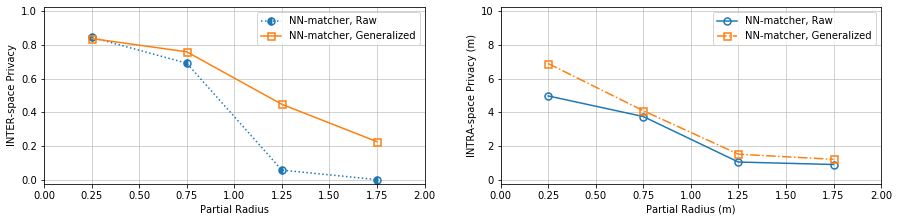

In [46]:
fig=plt.figure(figsize=(15, 3.25))

RawNN = np.asarray(results_partials[0])
RansacNN = np.asarray(results_partials[1])

ax1 = fig.add_subplot(121) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,2.0)
ax1.set_ylabel("INTER-space Privacy")
ax1.set_xlabel("Partial Radius")

markersize = 7
linewidth = 1.5

ax1.plot(
    RawNN[:,0],RawNN[:,1],
    ":o",
    linewidth = linewidth,fillstyle = 'left',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher, Raw"
)
ax1.plot(
    RansacNN[:,0],
    RansacNN[:,1],
    "-s",
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher, Generalized"
)


ax1.legend(loc = "upper right", ncol = 1, fontsize = 10);# bbox_to_anchor=(1.1, 1.5));

ax2 = fig.add_subplot(122) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(0,2)

ax2.set_ylabel("INTRA-space Privacy (m)")
ax2.set_xlabel("Partial Radius (m)")
#ax2.set_yticklabels(fontsize = 16)
#ax2.set_xticklabels(fontsize = 16)

#plt.minorticks_on()

ax2.plot(
    RawNN[:,0],
    RawNN[:,2], 
    linewidth = linewidth, 
    marker = 'o',fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher, Raw"
)
ax2.plot(
    RansacNN[:,0],
    RansacNN[:,2],
    '-.s',
    linewidth = linewidth,
    fillstyle = 'none',
    mew = linewidth,markersize = markersize,
    label = "NN-matcher, Generalized"
)

ax2.legend(loc = "upper right", ncol = 1, fontsize = 10);#, bbox_to_anchor=(1.1, 1.5));

plt.savefig('plots/one-time-partials-spaces.png', format='png', dpi=300,bbox_inches = 'tight')
